In [21]:
import pandas as pd
import numpy as np
import os
import sys

import pickle
from datetime import datetime


from scipy.stats import ttest_ind, mannwhitneyu


import tensorflow as tf

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

# preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


# Reshaping 
from tensorflow import reshape
from tensorflow.image import resize_with_pad


# Modelling 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# metrics
from tensorflow.keras.metrics import Recall, AUC


%matplotlib inline



module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import data, graphs, eda
plt.style.use('ggplot')
np.random.seed(42)

# Check class imbalance and look at examples from each

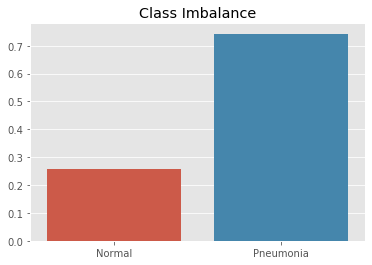

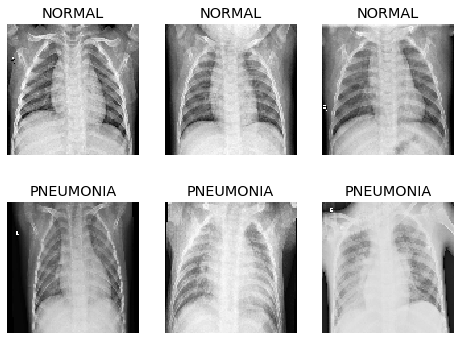

In [2]:
train_dir = './src/data/chest_xray/train/' # image folder

# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)


# Visualize the class imbalance
import seaborn as sns

normal_size = len(normal_imgs)/(len(normal_imgs)+len(pneumo_imgs))
pnue_size = len(pneumo_imgs)/(len(normal_imgs)+len(pneumo_imgs))

ax = sns.barplot(x = ['Normal', 'Pneumonia'],
                 y = [normal_size, pnue_size]);
ax.set_title("Class Imbalance");


# plotting 3 of each class 
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

The first thing to note is that we have a class imbalance between healthy and pnuemonia patients where there are fewer healthy picture than ones with pnuemonia. In medical imaging this is a common occurance. The people who are sicker are more likely to recieve chest x rays and therefore we would expect there to be a higher number of x rays featuring patients with pnueomonia.

The image above shows three healthy chest xrays and three chest xrays of patients with pneumonia. Patients with pnuemonia have less defined organ structures. There is generally a "haze" around the lung area. This haze is caused by a build up of fluid and scarring caused by bacterial or viral infections causing the pnuemonia.

However, this is just a small sample, in fact, the central pneuomonia image is take from the side whereas the other 5 images are taken from the anterior to posterior axis.

To see if there are differences in the in the xrays of sick versus healthy patients overall, calculated the mean value for each pixel in the image array and took the mean of those pixels.

To do this, we imported each picture seperately, adjusted their size so that they are all 224,224 and converted them to grayscale. We then flattened the two dimensional array to 1 dimension using np.ravel() and concatenated all of the vectors into one matrix call full_mat (full_matrix).

Once we had our full matrix, we took the mean accross each row (matching pixels in the image) concatenated them into an n X m matrix

In [5]:
# making n X m matrix
# run it on our folders
normal_images = eda.image_to_matrix(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = eda.image_to_matrix(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

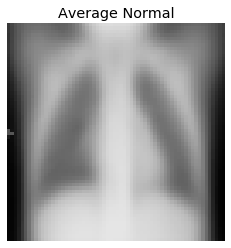

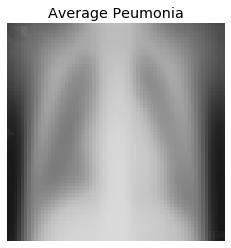

In [6]:
# Get the mean of each matrix on axis=0 and convert back to a 64,64 matrix
norm_mean = eda.find_mean_img(normal_images, 'Normal')
pneu_mean = eda.find_mean_img(pnemonia_images, 'Peumonia')

Our intuition from seeing 3 random images held true in the aggregate. The Average Pneumonia x-ray chest cavity is blurred, likely by the fluid and scarification from the their infection. 

Visual analysis built our intuition that there is a difference between between each pixel. We wanted to visualize the difference between the means of the images to demonstrate the regions where the differences in pixel value was greatest.

However, our pneumonia cases contained both viral and bacterial pneumonia patients. We decided to see if there was also a noticeable difference between those two groups. If there was, we would have to deal with in the modelling step.

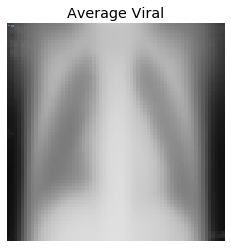

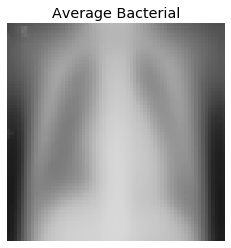

In [10]:
# Get viral and bacterial fn
viral_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg') and fn.find("virus") != -1]
bacterial_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg') and fn.find('bacteria') != -1]

# observe class imbalance
viral_size = len(viral_imgs)/(len(viral_imgs)+len(bacterial_imgs))
bacterial_size = len(bacterial_imgs)/(len(bacterial_imgs)+len(viral_imgs))

ax = sns.barplot(x = ['Viral', 'Bacterial'],
                 y = [viral_size, bacterial_size]);
ax.set_title("Class Imbalance Between Viral and Bacterial Pneumonia");

# get viral and bacterial full matrices
viral_fm = eda.image_to_matrix(f'{train_dir}/PNEUMONIA/', viral_imgs)
bacterial_fm = eda.image_to_matrix(f'{train_dir}/PNEUMONIA/', bacterial_imgs)

# Display the mean differences in the 
viral_mean = eda.find_mean_img(viral_fm, 'Viral')
bacterial_mean = eda.find_mean_img(bacterial_fm, 'Bacterial')

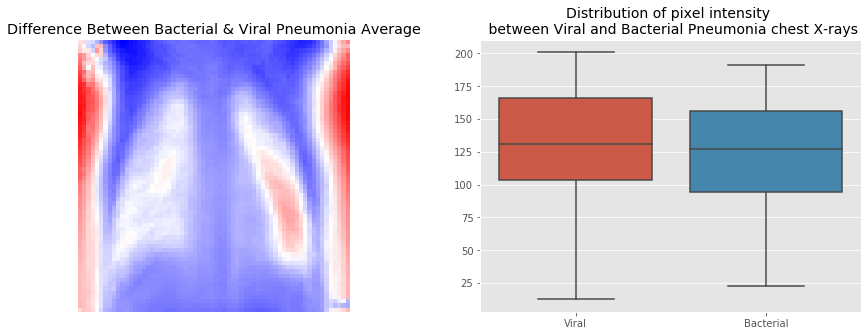

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

contrast_mean = bacterial_mean - viral_mean
ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title(f'Difference Between Bacterial & Viral Pneumonia Average')
ax[0].axis('off')

# visualize pixel instensity distributions
viral_arr = viral_mean.ravel()
bac_arr = bacterial_mean.ravel()


# Create a dataframe
bac_vir = pd.DataFrame([(viral_arr),(bac_arr)]).T
bac_vir.columns = ['Viral', 'Bacterial']

sns.boxplot(data=bac_vir, ax=ax[1]);
ax[1].set_title("Distribution of pixel intensity \n between Viral and Bacterial Pneumonia chest X-rays", size=14);

Its seems that perhaps viral pneumonia is produces less fluid and scarring in lungs. This may be an issue in our modelling stage as the overall pixel within the lungs in the viral x rays is not as high as those with pnuemonia.

The pixel distributions in this case are perhaps misleading. It would seem that viral x rays are brighter over all but that runs counter to what we observed. It could be that patients who had bacterial pneumonia were simply younger over all and small and the xray didn't pick up as much of their bones as they still have a lot of cartiledge. However, since we don't have access to patient age, this is a confounding factor we can only speculate on. 

Now that we examined our subclasses of pneumonia, let's join them back together into one class and compare the means between Normal and Pneuomonia patients.

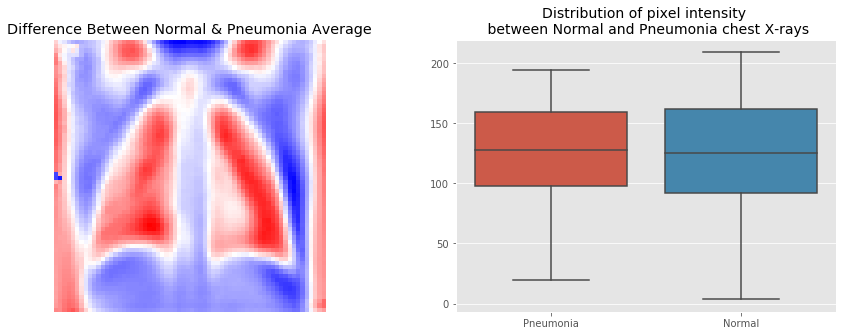

In [31]:
contrast_mean = pneu_mean - norm_mean


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title(f'Difference Between Normal & Pneumonia Average')
ax[0].axis('off')

# flatten matrices
pnue_mean_arr = pneu_mean.ravel()
norm_mean_arr = norm_mean.ravel()


sick_healthy = pd.DataFrame([(pnue_mean_arr),(norm_mean_arr)]).T
sick_healthy.columns = ['Pneumonia', 'Normal']


sns.boxplot(data=sick_healthy, ax=ax[1]);
plt.title("Distribution of pixel intensity \n between Normal and Pneumonia chest X-rays", size=14);

Pixels that are blue are closer to 0 and pixels that are red are closer 255. We calculated the difference by subtracting the healthy individual's average pixel value away from the the pneuomonia patients pixel value. Therefore, the more red a region is, the brighter the region was in sick patients than in healthy ones. The result was that the chest cavity, specifically the lungs of the patients were far brighter in the pneumonia patients than in healthy individuals. 

In addition to the mean difference between pixels, we also were interested in the variance between pixels for each group. To do this, we repeated the above steps, defining a new function that takes as it's arguement full matrix and returns the variance of each pixel in the matrix.

In order to increase the brightness, we raised the pixel standard deviation to 1.1 so that the bright areas were amplified. 

When we look look at th box and whisker graph of the pixel distributions, a similar pattern emerges to what we observed via visual analysis. Though normal chest xrays have a larger range of pixel values, the median pixel intensity for pneumonia chest xrays was higher than Normal. In addition, the IQR was reduced in Pneumonia x-rays (70 vs 61). In addition, the max and min values between the classes was different. Normal x-rays had a maximal pixel intensity of 209 while Pnuemonia xrays had a maximal pixel instensity of 194.


It seems that Normal images on average have a wider range of pixel values than pneumonia images but pneumonia images have a greater mean and median overall, however, the results were not significant:

In [22]:
ttest = ttest_ind((pnue_mean_arr),(norm_mean_arr), equal_var=False) # parametric
manny = mannwhitneyu((pnue_mean_arr),(norm_mean_arr)) # non-parametric

print(f"The two sample independent ttest failed to reject the null hypotheis: p = {round(ttest[1], 2)}", end ='\n\n')

print(f"The Mann–Whitney U test also failed to reject the null hypotheis: p = {round(manny[1], 2)}")

The two sample independent ttest failed to reject the null hypotheis: p = 0.47

The Mann–Whitney U test also failed to reject the null hypotheis: p = 0.33


In [26]:
# Descriptive statistics between the images
IQR = sick_healthy.describe().loc['75%'] - sick_healthy.describe().loc['25%']
print(f"Inter Quartile Range of Pixel Intensity: \n\n{IQR}")
sick_healthy.describe()

Inter Quartile Range of Pixel Intensity: 

Pneumonia    61.482712
Normal       69.970358
dtype: float64


,Pneumonia,Normal
count,4096.000000,4096.000000
mean,123.181543,122.410553
std,45.474666,51.337497
min,19.471483,3.404922
25%,97.876579,91.786726
50%,127.727871,125.328487
75%,159.359291,161.757084
max,194.148911,209.061890


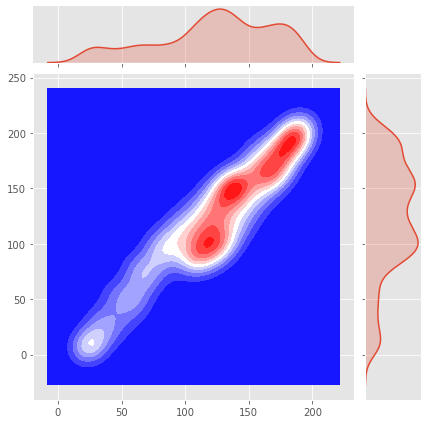

In [27]:
# Flatten out the mean matrices 
pnue_mean_arr = (pneu_mean.ravel())
norm_mean_arr = (norm_mean.ravel())

ax = sns.jointplot(x=pnue_mean_arr, y=norm_mean_arr, 
               kind='kde', cmap='bwr');



The multivariate KDE plot shows which intensities are common between the classes while displaying the distributions of both. The distributions don't look very different from one another which reinforces the statistical tests that failed to reject the null hypothesis.

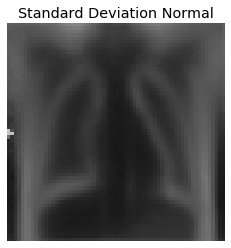

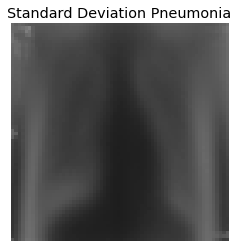

In [29]:
norm_std = eda.find_var_img(normal_images, 'Normal')
pneu_std = eda.find_var_img(pnemonia_images, 'Pneumonia')

The patients with pnuemonia had greater variation accross their entire lung area whereas healthy patients tended to have variation in the size of their lungs, given by the outline in the of the lung having a higher standard deviation. 

Similar to mean pixel intensity, let's look at the differences between the two classes in the standard deviation of the pixels

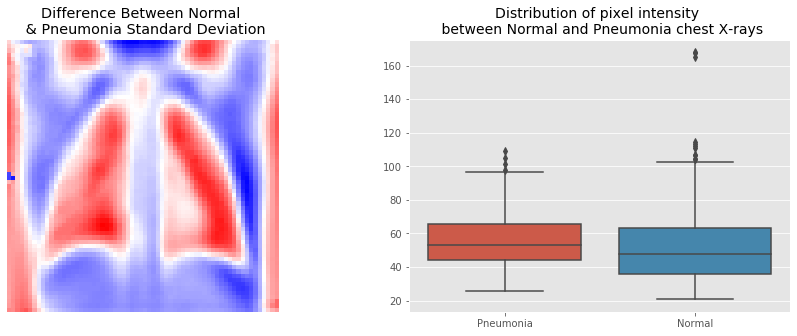

In [33]:
contrast_std = pneu_std -norm_std


fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax[0].imshow(contrast_mean, cmap='bwr')
ax[0].set_title(f'Difference Between Normal \n & Pneumonia Standard Deviation')
ax[0].axis('off')

# flatten matrices
pnue_std_arr = pneu_std.ravel()
norm_std_arr = norm_std.ravel()


sick_healthy = pd.DataFrame([(pnue_std_arr),(norm_std_arr)]).T
sick_healthy.columns = ['Pneumonia', 'Normal']


sns.boxplot(data=sick_healthy, ax=ax[1]);
plt.title("Distribution of pixel standard deviation \n between Normal and Pneumonia chest X-rays", size=14);


Here, we can see that the overall shape of the lungs changed very little between the two classes. However, the pixel intensity within and around the lungs was much higher in the Pnuemonia class. This once again was to be expected. Pnuemonia doesn't effect all regions of the lungs uniformly. It can be more intense in specific regions however the lungs over all are similar in size whether or not you have an infection. 

A caveat to the above statement is that patients with pnuemonia's lungs appeared "longer" than those without. This is highlighted by the shadowy regions on either lower regions of the lung.  The reason for this is likely the accumulation of fluid at the base of the lungs being detected by the x ray.

Next, we wanted to use eigendecomposition/principal component analysis to find which features of the image stand out and potentially reduce the dimensions of our data set for future modelling. This process is also called eigenfaces, and was first usedin 1987 by Turk and Pentland for face classification. However it can be broadly used to extract the most important features from images in each class. 

To acheive this, we will use the sklaern PCA implementation but we will only look at eigenimages that explain 60% of the total varation in the dataset.

Number of Pneumonia PC:  7


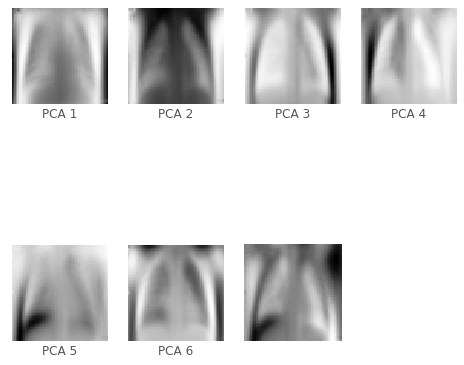

Number of Normal PC:  14


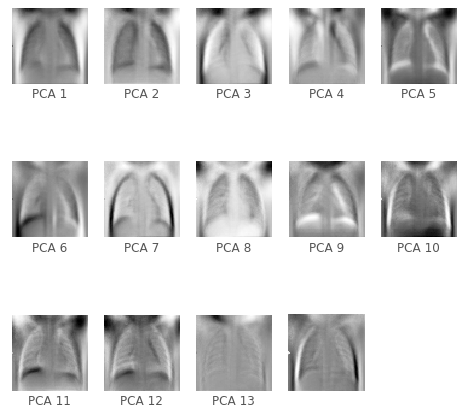

In [35]:
eda.plot_pca(eda.eigenimages(pnemonia_images, 'Pneumonia'))
eda.plot_pca(eda.eigenimages(normal_images, 'Normal')) 

Interestingly, in order to explain 60% of the variation in the data sets, you needed twice the number of PCA's from the healthy class than the sick class. A theorized reason for this is that since the healthy class had less variance over all, the difference between features was less impactful. 


Interestingly, PCA 1 of pnuemonia revealed that over all brightness of the image was indicative of the class. The next PCA highlights the size of the lungs themselves. Healthy PCA1, PCA2 and PCA3 on the otherhand are all highlighting well defined edges around the lungs. Likely, this is due to our previous finding that the variation around in the size of the lung larger than the variation within the lungs for healthy patients.


We hope that our cnn will be able to pull out those contours in the convolutions.

# Our takeaways from EDA:
- Class Imbalance:
    - There are 3x the number of x rays of infected lungs than healthy we will address this via:
        - Data Augmentation, though we are hesitant about using augmentation on medical images.
            - Rotations, shifts and inversions
        - Class weighting. We will calculate the inverse class frequency and use those as the weights in our model
- Feature Selection:
    - We hope to train our CNN to pick out 3 key features:
        - Cloudiness of the image/overall brightness
        - The dark well defined chest cavity of healthy people
        - The region at the base of the lungs corresponding to build up of fluids
